# GNN-Based Link Prediction in Drug-Drug Interaction Networks
Welcome! This colab serves as a tutorial for using Graph Machine Learning to perform Link Prediction in the drug-drug interaction dataset. Particularly, we focus on applying **GraphSage**, a type of **Graph Neural Network (GNN)**, to the `ogbl-ddi` dataset.

Over the course of this colab, we will begin development from the ground-up: from downloading the dataset, to writing training code to prepare a base model using [PyTorch Geometric (PyG)](https://pytorch-geometric.readthedocs.io/en/latest/), to implementing increasingly advanced techniques to try and improve our performance. We would strongly encourage you to make use of GPU runtime as you go through this notebook. Now, let's get started!



## Setup

### Installation

We first will install PyG as well as [ogb](https://github.com/snap-stanford/ogb).

In [ ]:
import torch
import os
print("PyTorch has version {}".format(torch.__version__))

PyTorch has version 1.10.0+cu111


In [ ]:
!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
!pip install torch-geometric
!pip install ogb

Looking in links: https://data.pyg.org/whl/torch-1.10.0+cu111.html
Looking in links: https://data.pyg.org/whl/torch-1.10.0+cu111.html


### Imports

In [ ]:
import torch
import torch.nn.functional as F
import networkx as nx
import random
import torch_geometric.transforms as T

from torch import Tensor
from torch.utils.data import DataLoader
from torch_geometric.utils import negative_sampling, convert, to_dense_adj
from torch_geometric.nn import GCNConv, SAGEConv
from torch_geometric.nn.conv import MessagePassing
from ogb.linkproppred import PygLinkPropPredDataset, Evaluator

## Dataset
As mentioned above, the dataset that we are working with is [ogbl-ddi](https://ogb.stanford.edu/docs/linkprop/#ogbl-ddi). Briefly, in the homogenous, feature-less, undirected graph, each node represents a drug. Edges between nodes represent interactions between the drugs, where the joint effect of taking both drugs is markedly different than the expected effects if either drug was taken independently.

### Installation and Exploration

The `ogb` library makes downloading an official ogb dataset, like ogbl-ddi, incredibly easy.

Below, we download the (non-sparse) version of the dataset and explore it using NetworkX, a popular Python library for working with graphs/networks. To do so, we leverage PyG utilities to convert the dataset into a NetworkX graph.

In [ ]:
dataset = PygLinkPropPredDataset(name='ogbl-ddi')
data = dataset[0]
G = convert.to_networkx(data, to_undirected=True)

/usr/local/lib/python3.7/dist-packages/torch_geometric/data/storage.py:264: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'edge_index'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  " to suppress this warning")


We know gather some statistics about the graph using NetworkX.

In [ ]:
num_nodes, num_edges = G.number_of_nodes(), G.number_of_edges()
print(f'ogbl-ddi has {num_nodes} nodes and {num_edges} edges, with an average node degree of {round(2 * num_edges / num_nodes)}')


ogbl-ddi has 4267 nodes and 1067911 edges, with an average node degree of 501


We wrap up our exploration of this graph by visualizing a subgraph of it (feel free to adjust `num_nodes_to_sample` to see more or less of the graph, though anything above 1000 will take a bit of time to render).

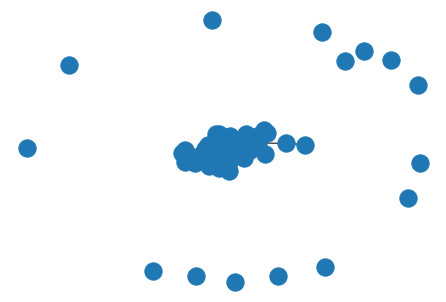

In [ ]:
num_nodes_to_sample = 100
sampled_nodes = random.sample(G.nodes, num_nodes_to_sample)
sampled_graph = G.subgraph(sampled_nodes)
nx.draw(sampled_graph, with_labels=False)

Now, it's time to download the sparse version of the graph that we are actually going to make use of when developing models. We will use this version of the dataset to get our edge splits (train, validation, test).


In [ ]:
dataset = PygLinkPropPredDataset(name='ogbl-ddi',
                                     transform=T.ToSparseTensor())
device = 'cuda' if torch.cuda.is_available() else 'cpu'
data = dataset[0]
adj_t = data.adj_t.to(device)
split_edge = dataset.get_edge_split()

/usr/local/lib/python3.7/dist-packages/torch_geometric/data/storage.py:264: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'edge_index'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  " to suppress this warning")


Finally, as ogbl-ddi has no node features, we will initialize our own (constant) initial embeddings for all the nodes. We will make use of `emb` once we get into the thick of training our own model below. Note, to be more inductive, we have opted not to make our embeddings learned parameters, unlike prior work with ogbl-ddi.

In [ ]:
emb = torch.ones(num_nodes, 1).to(device)

## Base GraphSage Model

Now that we have our dataset downloaded, we can begin building our baseline model using PyG!

Our base model consists of (1) the GraphSage GNN for generating node embeddings (2) a basic LinkPredictor that simply does a dot product between the two node embeddings followed by a sigmoid. Notice that we are leveraging the built-in [SAGEConv](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.SAGEConv) layer from PyG, which allows us to quickly get our model up and running. Our base model is heavily inspired by the ogb sample code for ogbl-ddi, which can be found here: https://github.com/snap-stanford/ogb/blob/master/examples/linkproppred/ddi/gnn.py

In [ ]:
class SAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers,
                 dropout, aggr="add"):
        super(SAGE, self).__init__()

        self.convs = torch.nn.ModuleList()
        self.convs.append(SAGEConv(in_channels, hidden_channels, normalize=True, aggr=aggr))
        for _ in range(num_layers - 2):
            self.convs.append(SAGEConv(hidden_channels, hidden_channels, normalize=True, aggr=aggr))
        self.convs.append(SAGEConv(hidden_channels, out_channels, normalize=True, aggr=aggr))

        self.dropout = dropout

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()

    def forward(self, x, adj_t):
        for conv in self.convs[:-1]:
            x = conv(x, adj_t)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.convs[-1](x, adj_t)
        return x

class DotProductLinkPredictor(torch.nn.Module):
    def __init__(self):
        super(DotProductLinkPredictor, self).__init__()

    def forward(self, x_i, x_j):
        out = (x_i*x_j).sum(-1)
        return torch.sigmoid(out)

    def reset_parameters(self):
      pass

To help familiarize readers with how the GNN and LinkPredictor work, below we apply the untrained model to the training graph and use the output node embeddings to make link predictions. While the results will be terrible, it does give a good sense of how to make use of these PyG-based models.

We have chosen a `hidden_dimension` / embedding dimensionality of 256. As the diameter of the graph (computed using NetworkX [diameter](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.distance_measures.diameter.html) method; not included in this Colab as it takes a long time to run) is 5 and a general rule of thumb says to keep the receptive field of the GNN slightly higher than that, we have chosen a 7-layer GraphSage model.

In [ ]:
# Initialize our model and LinkPredictor
hidden_dimension = 256
model = SAGE(1, hidden_dimension, hidden_dimension, 7, 0.5).to(device)
predictor = DotProductLinkPredictor().to(device)

# Run our initial "node features" through the GNN to get node embeddings
model.eval()
predictor.eval()
h = model(emb, adj_t)

# Randomly sample some training edges and pass them through our basic predictor
idx = torch.randperm(split_edge['train']['edge'].size(0))[:10]
edges = split_edge['train']['edge'][idx].t()
predictor(h[edges[0]], h[edges[1]])

tensor([0.7311, 0.7311, 0.7311, 0.7311, 0.7311, 0.7311, 0.7311, 0.7311, 0.7311,
        0.7311], device='cuda:0', grad_fn=<SigmoidBackward0>)

##Training and Evaluation

Now we will define functions that we will use for training and evaluating our models! Once again, we took much inspiration from https://github.com/snap-stanford/ogb/blob/master/examples/linkproppred/ddi/gnn.py.

### Training Drivers
We leverage a fairly standard PyTorch training loop. For each batch of positive edges from our initial training split, we leverage PyG's [negative_sampling](https://pytorch-geometric.readthedocs.io/en/latest/modules/utils.html?highlight=negative_sampling#torch_geometric.utils.negative_sampling) utility to create an equivalently sized batch of negative edges (i.e. edges NOT present in the training graph). The complete training batch thus contains an equal amount of positive and negative edges.

For every batch, we generate node embeddings using all the training edges. We then make link predictions for the current batch and compute our loss, from which we backpropagate  to update our model.

In [ ]:
def create_train_batch(all_pos_train_edges, perm, edge_index):
    # First, we get our positive edges, reshaping them to the form (2, hidden_dimension)
    pos_edges = all_pos_train_edges[perm].t().to(device)

    # We then sample the negative edges using PyG functionality
    neg_edges = negative_sampling(edge_index, num_nodes=num_nodes,
                                  num_neg_samples=perm.shape[0], method='dense').to(device)

    # Our training batch is just the positive edges concatanted with the negative ones
    train_edge = torch.cat([pos_edges, neg_edges], dim=1)

    # Our labels are all 1 for the positive edges and 0 for the negative ones
    pos_label = torch.ones(pos_edges.shape[1], )
    neg_label = torch.zeros(neg_edges.shape[1], )
    train_label = torch.cat([pos_label, neg_label], dim=0).to(device)

    return train_edge, train_label

def train(model, predictor, x, adj_t, split_edge, loss_fn, optimizer, batch_size, num_epochs, edge_model=False, spd=None):
  # adj_t isn't used everywhere in PyG yet, so we switch back to edge_index for negative sampling
  row, col, edge_attr = adj_t.t().coo()
  edge_index = torch.stack([row, col], dim=0)

  model.train()
  predictor.train()

  model.reset_parameters()
  predictor.reset_parameters()

  all_pos_train_edges = split_edge['train']['edge']
  for epoch in range(num_epochs):
    epoch_total_loss = 0
    for perm in DataLoader(range(all_pos_train_edges.shape[0]), batch_size,
                           shuffle=True):
      optimizer.zero_grad()

      train_edge, train_label = create_train_batch(all_pos_train_edges, perm, edge_index)

      # Use the GNN to generate node embeddings
      if edge_model:
        h = model(x, edge_index, spd)
      else:
        h = model(x, adj_t)

      # Get predictions for our batch and compute the loss
      preds = predictor(h[train_edge[0]], h[train_edge[1]])
      loss = loss_fn(preds, train_label)

      epoch_total_loss += loss.item()

      # Update our parameters
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
      torch.nn.utils.clip_grad_norm_(predictor.parameters(), 1.0)
      optimizer.step()
    print(f'Epoch {epoch} has loss {round(epoch_total_loss, 4)}')

### Evaluation Drivers
Our evaluation code is also fairly standard PyTorch. As our validation and test splits from ogb already come with negative edges, we are able to easily leverage them instead of generating our own.

Like with the training code, we use the training graph to generate node embeddings using our GNN. We then calculate predictions using the LinkPredictor for our positive and negative edges. Although we calculate accuracy ourselves, we leverage the [Evaluator](https://github.com/snap-stanford/ogb/blob/68a303f320220cda859e83e3a8660f2b9debedf6/ogb/linkproppred/evaluate.py#L11) provided by the ogb library for ogbl-ddi to calculate Hits@K. Though we demonstrate how to calculate Hits@K for several values of K, in keeping with prior work, we focus on Hits@20 as our primary metric.

In [ ]:
def accuracy(pred, label):
  pred_rounded = torch.round(pred)
  accu = torch.eq(pred_rounded, label).sum() / label.shape[0]
  accu = round(accu.item(), 4)
  return accu

@torch.no_grad()
def test(model, predictor, x, adj_t, split_edge, evaluator, batch_size, edge_model=False, spd=None):
    model.eval()
    predictor.eval()

    if edge_model:
        # adj_t isn't used everywhere in PyG yet, so we switch back to edge_index
        row, col, edge_attr = adj_t.t().coo()
        edge_index = torch.stack([row, col], dim=0)
        h = model(x, edge_index, spd)
    else:
        h = model(x, adj_t)

    pos_eval_edge = split_edge['edge'].to(device)
    neg_eval_edge = split_edge['edge_neg'].to(device)

    pos_eval_preds = []
    for perm in DataLoader(range(pos_eval_edge.shape[0]), batch_size):
        edge = pos_eval_edge[perm].t()
        pos_eval_preds += [predictor(h[edge[0]], h[edge[1]]).squeeze().cpu()]
    pos_eval_pred = torch.cat(pos_eval_preds, dim=0)

    neg_eval_preds = []
    for perm in DataLoader(range(neg_eval_edge.size(0)), batch_size):
        edge = neg_eval_edge[perm].t()
        neg_eval_preds += [predictor(h[edge[0]], h[edge[1]]).squeeze().cpu()]
    neg_eval_pred = torch.cat(neg_eval_preds, dim=0)

    total_preds = torch.cat((pos_eval_pred, neg_eval_pred), dim=0)
    labels = torch.cat((torch.ones_like(pos_eval_pred), torch.zeros_like(neg_eval_pred)), dim=0)
    acc = accuracy(total_preds, labels)

    results = {}
    for K in [10, 20, 30, 40, 50]:
        evaluator.K = K
        valid_hits = evaluator.eval({
            'y_pred_pos': pos_eval_pred,
            'y_pred_neg': neg_eval_pred,
        })[f'hits@{K}']
        results[f'Hits@{K}'] = (valid_hits)
    results['Accuracy'] = acc

    return results
eval = Evaluator(name='ogbl-ddi')
# ogb Evaluators can be invoked to get their expected format
print(eval.expected_input_format)

==== Expected input format of Evaluator for ogbl-ddi
{'y_pred_pos': y_pred_pos, 'y_pred_neg': y_pred_neg}
- y_pred_pos: numpy ndarray or torch tensor of shape (num_edge, ). Torch tensor on GPU is recommended for efficiency.
- y_pred_neg: numpy ndarray or torch tensor of shape (num_edge, ). Torch tensor on GPU is recommended for efficiency.
y_pred_pos is the predicted scores for positive edges.
y_pred_neg is the predicted scores for negative edges.
Note: As the evaluation metric is ranking-based, the predicted scores need to be different for different edges.


### Train and Evaluate Baseline Model
Now we are ready to kick-off training of our base model and evaluate it with our validation set. As we will do with all of our models, we make use of the Adam optimizer and Binary Cross-Entropy loss. Readers should feel free to experiment with other optimizers/loss functions as they see fit.

*This cell will take around 2-3 minutes to run.*

In [ ]:
optimizer = torch.optim.Adam(
            list(model.parameters())  +
            list(predictor.parameters()), lr=0.01)
train(model, predictor, emb, adj_t, split_edge, torch.nn.BCELoss(),
      optimizer, 64 * 1024, 30)
test(model, predictor, emb, adj_t, split_edge["valid"], Evaluator(name='ogbl-ddi'), 64*1024)

Epoch 0 has loss 11.7615
Epoch 1 has loss 10.2765
Epoch 2 has loss 10.2979
Epoch 3 has loss 10.2866
Epoch 4 has loss 10.1668
Epoch 5 has loss 10.0116
Epoch 6 has loss 9.8391
Epoch 7 has loss 9.7661
Epoch 8 has loss 9.7133
Epoch 9 has loss 9.6638
Epoch 10 has loss 9.6304
Epoch 11 has loss 9.6339
Epoch 12 has loss 9.6006
Epoch 13 has loss 9.5866
Epoch 14 has loss 9.6137
Epoch 15 has loss 9.5235
Epoch 16 has loss 9.5124
Epoch 17 has loss 9.5054
Epoch 18 has loss 9.4676
Epoch 19 has loss 9.4846
Epoch 20 has loss 9.4448
Epoch 21 has loss 9.4771
Epoch 22 has loss 9.4466
Epoch 23 has loss 9.4306
Epoch 24 has loss 9.4244
Epoch 25 has loss 9.4346
Epoch 26 has loss 9.4441
Epoch 27 has loss 9.4275
Epoch 28 has loss 9.4073
Epoch 29 has loss 9.4163


{'Accuracy': 0.7764,
 'Hits@10': 0.0,
 'Hits@20': 0.0,
 'Hits@30': 0.0,
 'Hits@40': 0.0,
 'Hits@50': 0.004674542471664332}

Our base model performs pretty poorly: while accuracy may be decent, Hits@K reveal that it does not do a good job distinguishing negative edges from positive ones.

Our basic model is just not expressive enough. But we can now guide readers through how the basic model can be improved.

## Model Enhancements
With our baseline model successfully trained, we now shift our attention to improving the model itself using a variety of different Graph Machine Learning techniques.

### Robust GNN
Our basic GraphSage implementation (using 'add' aggregation) was little more than successive GNN layers stacked on top of each other.

Just adding more layers onto a GNN can get detrimental, as we can just end up with embeddings all being the same. However, PyG allows us to easily enhance our GNN model in other ways, such as by adding skip-connections between layers, batch normalization, and even post-processing layers. Let's put some of these ideas to use.

#### Skip-Connection

A skip-connection, in theory, allows us to have more layers in our GNN. This would allow us to incorporate information from larger k-hop neighborhoods, while somewhat mitigating the risk of over-smoothing node embeddings.

We can quickly build upon our base `SAGE` model to include skip-connections, as demonstrated below.

In [ ]:
class SkipConnSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_dimension, out_channels, num_layers,
                 dropout):
        super(SkipConnSAGE, self).__init__()

        self.convs = torch.nn.ModuleList()

        self.convs.append(SAGEConv(in_channels, hidden_dimension, normalize=True, aggr="add"))
        for _ in range(num_layers - 2):
            self.convs.append(SAGEConv(hidden_dimension, hidden_dimension, normalize=True, aggr="add"))
        self.convs.append(SAGEConv(hidden_dimension, out_channels, normalize=True, aggr="add"))

        self.dropout = dropout

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()

    def forward(self, x, adj_t):
        prev_x = None
        for i in range(len(self.convs) - 1):
          prev_x = x
          x = self.convs[i](x, adj_t)
          # Skip Connection
          if i > 0:
            x = x + prev_x
          x = F.relu(x)
          x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.convs[-1](x, adj_t)
        return x

With our `SkipConnSAGE` model defined, we can now initiate its training end evaluation, just as we did with `SAGE` before. This time, we will use 10 `SAGEConv` layers.

*This cell will take around 10 minutes to run.*

In [ ]:
# Initialize our enhanced model and LinkPredictor
model = SkipConnSAGE(1, hidden_dimension, hidden_dimension, 10, 0.5).to(device)
predictor = DotProductLinkPredictor().to(device)

optimizer = torch.optim.Adam(
            list(model.parameters())  +
            list(predictor.parameters()), lr=0.01)
train(model, predictor, emb, adj_t, split_edge, torch.nn.BCELoss(),
      optimizer, 64 * 1024, 100)
test(model, predictor, emb, adj_t, split_edge["valid"], Evaluator(name='ogbl-ddi'), 64*1024)

Epoch 0 has loss 12.1889
Epoch 1 has loss 10.7741
Epoch 2 has loss 10.4716
Epoch 3 has loss 10.3604
Epoch 4 has loss 10.3707
Epoch 5 has loss 10.2429
Epoch 6 has loss 10.2347
Epoch 7 has loss 10.1862
Epoch 8 has loss 10.1846
Epoch 9 has loss 10.1771
Epoch 10 has loss 10.1501
Epoch 11 has loss 10.1961
Epoch 12 has loss 10.2139
Epoch 13 has loss 10.1737
Epoch 14 has loss 10.1412
Epoch 15 has loss 10.1316
Epoch 16 has loss 10.138
Epoch 17 has loss 10.1327
Epoch 18 has loss 10.1366
Epoch 19 has loss 10.069
Epoch 20 has loss 10.0609
Epoch 21 has loss 10.0815
Epoch 22 has loss 10.0427
Epoch 23 has loss 10.0846
Epoch 24 has loss 10.0922
Epoch 25 has loss 10.0285
Epoch 26 has loss 9.9897
Epoch 27 has loss 9.9965
Epoch 28 has loss 9.9828
Epoch 29 has loss 10.0205
Epoch 30 has loss 9.9745
Epoch 31 has loss 9.958
Epoch 32 has loss 9.9662
Epoch 33 has loss 9.9283
Epoch 34 has loss 9.8914
Epoch 35 has loss 9.8758
Epoch 36 has loss 9.8331
Epoch 37 has loss 9.7715
Epoch 38 has loss 9.8131
Epoch 39 ha

{'Accuracy': 0.5671,
 'Hits@10': 0.0,
 'Hits@20': 0.0,
 'Hits@30': 0.0,
 'Hits@40': 0.0,
 'Hits@50': 0.0}

Alas, skip-connections actually seem to be deterimental for ogbl-ddi. Even reducing the number of GNN layers back down to 7 (or even 5) does not significantly improve performance. An in-depth analysis of what went wrong here can be found in the corresponding Medium post.

#### Post-Processing Layers
We can also try including post-processing layers in our GNN that do not pass messages, but simply apply a neural network to the embeddings. This can be convenient when the embeddings need to be used in a downstream task, such as the link prediction we wish to perform.

Below, we augment our base `SAGE` model with additional post-processing linear layers that are applied to the output of the GNN layers.

In [ ]:
class PostProcessSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_dimension, out_channels, num_conv_layers,
                 num_linear_layers, dropout):
        super(PostProcessSAGE, self).__init__()

        self.convs = torch.nn.ModuleList()
        self.lins = torch.nn.ModuleList()

        self.convs.append(SAGEConv(in_channels, hidden_dimension, normalize=True, aggr="add"))
        for _ in range(num_conv_layers - 1):
            self.convs.append(SAGEConv(hidden_dimension, hidden_dimension, normalize=True, aggr="add"))

        for _ in range(num_linear_layers - 1):
            self.lins.append(torch.nn.Linear(hidden_dimension, hidden_dimension))
        self.lins.append(torch.nn.Linear(hidden_dimension, out_channels))

        self.dropout = dropout

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()

    def forward(self, x, adj_t):
        for conv in self.convs[:-1]:
            x = conv(x, adj_t)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.convs[-1](x, adj_t)

        # Post-process
        for lin in self.lins[:-1]:
          x = lin(x)
          x = F.relu(x)
        x = self.lins[-1](x)
        return x

Let's now train and evaluate `PostProcessSAGE`, with 4 layers of post-processing.

*This cell will take around 10 minutes to run.*

In [ ]:
model = PostProcessSAGE(1, hidden_dimension, hidden_dimension, 7, 4, 0.5).to(device)
predictor = DotProductLinkPredictor().to(device)

optimizer = torch.optim.Adam(
            list(model.parameters())  +
            list(predictor.parameters()), lr=0.01)
train(model, predictor, emb, adj_t, split_edge, torch.nn.BCELoss(),
      optimizer, 64 * 1024, 100)
test(model, predictor, emb, adj_t, split_edge["valid"], Evaluator(name='ogbl-ddi'), 64*1024)

Epoch 0 has loss 11.8955
Epoch 1 has loss 11.7832
Epoch 2 has loss 11.4847
Epoch 3 has loss 11.3136
Epoch 4 has loss 10.956
Epoch 5 has loss 11.0432
Epoch 6 has loss 11.2958
Epoch 7 has loss 10.7023
Epoch 8 has loss 11.0348
Epoch 9 has loss 9.8048
Epoch 10 has loss 9.8009
Epoch 11 has loss 9.7332
Epoch 12 has loss 9.4423
Epoch 13 has loss 9.3573
Epoch 14 has loss 9.3478
Epoch 15 has loss 9.3611
Epoch 16 has loss 9.3328
Epoch 17 has loss 9.3153
Epoch 18 has loss 9.3002
Epoch 19 has loss 9.3038
Epoch 20 has loss 9.2778
Epoch 21 has loss 9.2568
Epoch 22 has loss 9.2601
Epoch 23 has loss 9.229
Epoch 24 has loss 9.1741
Epoch 25 has loss 9.1549
Epoch 26 has loss 9.1185
Epoch 27 has loss 9.0542
Epoch 28 has loss 9.0445
Epoch 29 has loss 9.0405
Epoch 30 has loss 9.0694
Epoch 31 has loss 9.0329
Epoch 32 has loss 9.0334
Epoch 33 has loss 9.0456
Epoch 34 has loss 9.1283
Epoch 35 has loss 9.0407
Epoch 36 has loss 9.0201
Epoch 37 has loss 9.0341
Epoch 38 has loss 9.0613
Epoch 39 has loss 9.0691
Epo

{'Accuracy': 0.7972,
 'Hits@10': 0.06408018638239855,
 'Hits@20': 0.11936564061458248,
 'Hits@30': 0.12729887855928204,
 'Hits@40': 0.14792230071391652,
 'Hits@50': 0.15880709271925028}

We see a modest performance boost over the baseline model! In particular, Hits@20 is now non-zero!

### Enhance LinkPredictor

Up until now, we have used a parameter-less LinkPredictor that just does a dot product between embeddings. However, given the performance boost we saw by performing post-processing on our node embeddings to make them better suited for link prediction, a logical next step would be to make our LinkPredictor its own neural network that we train alongside the GNN that generates the embeddings.

Below, we define such a `NeuralLinkPredictor`, which is just a small neural network created using traditional PyTorch modules. We once again heavily drew inspiration from https://github.com/snap-stanford/ogb/blob/master/examples/linkproppred/ddi/gnn.py.

In [ ]:
class NeuralLinkPredictor(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers,
                 dropout):
        super(NeuralLinkPredictor, self).__init__()

        self.lins = torch.nn.ModuleList()
        self.lins.append(torch.nn.Linear(in_channels, hidden_channels))
        for _ in range(num_layers - 2):
            self.lins.append(torch.nn.Linear(hidden_channels, hidden_channels))
        self.lins.append(torch.nn.Linear(hidden_channels, out_channels))

        self.dropout = dropout

    def reset_parameters(self):
        for lin in self.lins:
            lin.reset_parameters()

    def forward(self, x_i, x_j):
        x = x_i * x_j
        for lin in self.lins[:-1]:
            x = lin(x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.lins[-1](x)
        return torch.sigmoid(x).squeeze()

Let's see the benefits of using our `NeuralLinkPredictor` with our original `SAGE` model. We will kick-off training and evaluation with a 4-layer `NeuralLinkPredictor`.

*This cell will take around 10 minutes to run.*

In [ ]:
model = SAGE(1, hidden_dimension, hidden_dimension, 7, 0.5).to(device)
predictor = NeuralLinkPredictor(hidden_dimension, hidden_dimension, 1, 4, 0.5).to(device)
optimizer = torch.optim.Adam(
            list(model.parameters())  +
            list(predictor.parameters()), lr=0.01)
train(model, predictor, emb, adj_t, split_edge, torch.nn.BCELoss(),
      optimizer, 64 * 1024, 100)
test(model, predictor, emb, adj_t, split_edge["valid"], Evaluator(name='ogbl-ddi'), 64*1024)

Epoch 0 has loss 12.0659
Epoch 1 has loss 10.0522
Epoch 2 has loss 9.7123
Epoch 3 has loss 9.7045
Epoch 4 has loss 9.4551
Epoch 5 has loss 9.2476
Epoch 6 has loss 8.8489
Epoch 7 has loss 7.8619
Epoch 8 has loss 7.4604
Epoch 9 has loss 7.3953
Epoch 10 has loss 6.9876
Epoch 11 has loss 6.5006
Epoch 12 has loss 6.1975
Epoch 13 has loss 5.7866
Epoch 14 has loss 5.8142
Epoch 15 has loss 5.7181
Epoch 16 has loss 5.4725
Epoch 17 has loss 5.3401
Epoch 18 has loss 5.358
Epoch 19 has loss 5.2417
Epoch 20 has loss 5.1477
Epoch 21 has loss 5.0085
Epoch 22 has loss 5.0462
Epoch 23 has loss 5.1386
Epoch 24 has loss 4.977
Epoch 25 has loss 4.8947
Epoch 26 has loss 4.8313
Epoch 27 has loss 4.8141
Epoch 28 has loss 4.7011
Epoch 29 has loss 4.7146
Epoch 30 has loss 4.6313
Epoch 31 has loss 4.5789
Epoch 32 has loss 4.5772
Epoch 33 has loss 4.5209
Epoch 34 has loss 4.5832
Epoch 35 has loss 4.6198
Epoch 36 has loss 4.4905
Epoch 37 has loss 4.3566
Epoch 38 has loss 4.4068
Epoch 39 has loss 4.4023
Epoch 40 h

{'Accuracy': 0.9396,
 'Hits@10': 0.1789660571283027,
 'Hits@20': 0.32165197132347983,
 'Hits@30': 0.40468503022720975,
 'Hits@40': 0.4638209889953479,
 'Hits@50': 0.4911715572069609}

With 100 epochs, we get a considerable jump in performance, both on accuracy and Hits@K!. Clearly, a more expressive LinkPredictor can take these embeddings generated by our basic GNN and start making reasonably good predictions. However, our Hits@K is still fairly low, meaning we still have a considerable amount of negative edges scoring very high. We still have room for exploration!

Also, it's worth noting that although we chose to pass the element-wise product of the two node embeddings through the neural network for simplicity, a potentially better option could be to pass the concatenation of the two embeddings through instead. Experimenting with such a configuration, and others, can be easily done from our Colab and is left as an exercise to the reader.

## Node Feature Augmentation
While with the `NeuralLinkPredictor` we were able to achieve reasonable accuracy, we were still ranking many negative links fairly highly, causing our Hits@20 scores to fall.

As we saw above, trying to improve our GNN model, itself, gave mixed results. In a situation like this, with a homogenous graph with no features that seems to be hitting a wall with just GNN tweaks, we may instead want to augment our initial nodes with features we calculate on our own. Having distinct input features for each node may allow our GNN to produce better embeddings that allow for better link prediction.

### Generating Initial Node Features
Picking the right features is a delicate art that requires an intricate search. For demonstration purposes, we have chosen a handful of common features that can be easily calculated for each node using NetworkX. Below, we use those features to create our new initial features.

*This cell will take around 5-10 minutes to run. In particular, using a higher value of k for our approximation of betweenness centrality will take more time*

In [ ]:
# Calc the node stats that we are going to utilize
pagerank = nx.algorithms.link_analysis.pagerank_alg.pagerank(G)
clustering_coef = nx.algorithms.cluster.clustering(G)
betweeness_centrality = nx.betweenness_centrality(G, k=50)
degree = G.degree()

# Create initial node features from that
aug_emb = torch.ones(num_nodes, 5, dtype=torch.float64).to(device)
for i in range(num_nodes):
  aug_emb[i][0] = degree[i]
  aug_emb[i][1] = pagerank[i]
  aug_emb[i][2] = betweeness_centrality[i]
  aug_emb[i][3] = pagerank[i]
  aug_emb[i][4] = 1.0
aug_emb = aug_emb.float()

Let's now use these new node features and kick-off training. As we now have richer (and distinct) initial node features, we may not need to use as many GNN layers as before, which we experiment with below. Additionally, having seen the benefits of the `NeuralLinkPredictor`,  we continue to leverage it along with our base `SAGE` model.

*This cell will take around 10 minutes to run.*

In [ ]:
model = SAGE(5, hidden_dimension, hidden_dimension, 5, 0.5).to(device)
predictor = NeuralLinkPredictor(hidden_dimension, hidden_dimension, 1, 4, 0.5).to(device)
optimizer = torch.optim.Adam(
            list(model.parameters())  +
            list(predictor.parameters()), lr=0.01)
train(model, predictor, aug_emb, adj_t, split_edge, torch.nn.BCELoss(),
      optimizer, 64 * 1024, 100)
test(model, predictor, aug_emb, adj_t, split_edge["valid"], Evaluator(name='ogbl-ddi'), 64*1024)

Epoch 0 has loss 11.7797
Epoch 1 has loss 10.2298
Epoch 2 has loss 9.8303
Epoch 3 has loss 9.7739
Epoch 4 has loss 9.5056
Epoch 5 has loss 8.7571
Epoch 6 has loss 8.1665
Epoch 7 has loss 7.7742
Epoch 8 has loss 7.6725
Epoch 9 has loss 7.4331
Epoch 10 has loss 7.3427
Epoch 11 has loss 6.7041
Epoch 12 has loss 6.5088
Epoch 13 has loss 6.1485
Epoch 14 has loss 5.9559
Epoch 15 has loss 5.8623
Epoch 16 has loss 5.9244
Epoch 17 has loss 5.8425
Epoch 18 has loss 5.684
Epoch 19 has loss 5.7378
Epoch 20 has loss 5.6137
Epoch 21 has loss 5.5834
Epoch 22 has loss 5.706
Epoch 23 has loss 5.5933
Epoch 24 has loss 5.5229
Epoch 25 has loss 5.4564
Epoch 26 has loss 5.4345
Epoch 27 has loss 5.41
Epoch 28 has loss 5.3603
Epoch 29 has loss 5.3369
Epoch 30 has loss 5.3842
Epoch 31 has loss 5.4388
Epoch 32 has loss 5.3477
Epoch 33 has loss 5.3485
Epoch 34 has loss 5.2593
Epoch 35 has loss 5.2212
Epoch 36 has loss 5.2423
Epoch 37 has loss 5.1461
Epoch 38 has loss 5.114
Epoch 39 has loss 5.1362
Epoch 40 has 

{'Accuracy': 0.9167,
 'Hits@10': 0.24270913708245623,
 'Hits@20': 0.29468345706387794,
 'Hits@30': 0.3067293934331668,
 'Hits@40': 0.3067293934331668,
 'Hits@50': 0.3067293934331668}

There is a bit of variability between runs, but you should see that leveraging our `aug_emb` yields similar, and sometimes even better performance than using our constant features with the `NeuralLinkPredictor`! Just with some rudimentary node features, we are seeing solid performance. A more exhaustive feature search would likely yield even better performance.

## Distance Encoding / Edge Feature Augmentation
Just as we added node features to this homogenous, feature-less graph, we can also add edge-level features. Incorporating them into our GNN is trickier, but gives us the opportunity to peel back the layers of PyG and implement not just our own GNN model, but our own `MessagePassing` layer!

Prior work by [Lu et al.](https://github.com/lustoo/OGB_link_prediction/blob/main/Link%20prediction%20with%20structural%20information.pdf) found that distance encoding methods worked well for ogbl-ddi, as nodes that are estimated to be close together have a higher chance of being connected by an edge. We can incorporate the distances from each node to a set of anchor nodes and use those to estimate distances between any pairs of nodes. Rather than incorporate those distances during link prediction, we will instead directly factor those distances into our embeddings, treating the distances as edge features between nodes. Below, we present a slightly simplified spin on the current state-of-the-art approach developed in the aforementioned paper, which allows for easier understanding and a better illustration of how to leverage PyG's custom `MessagePassing` framework.

### Shortest Path Distances
First, we need to calculate the distance of each node to a set of randomly sampled anchor nodes. This will serve as the foundation of the 'edge features' we will utilize in our custom `MessagePassing` layer.

Below, we leverage NetworkX functionality to calculate the shortest path distances for each node. Each row in the `(num_nodes, K)`-shaped `spd` matrix contains the distances from the corresponding node to all K anchor nodes. We have set K = 200, but feel free to play around with the value to see what works best.

In [ ]:
K = 200
sampled_nodes = sorted(random.sample(G.nodes, K))

spd = torch.ones(num_nodes, K, dtype=torch.float64).to(device)
for k in range(K):
  distance_from_sample_k_to_all_nodes = nx.shortest_path_length(G, source=sampled_nodes[k])
  for node in distance_from_sample_k_to_all_nodes:
    spd[node][k] = distance_from_sample_k_to_all_nodes[node]
spd = spd.float()
spd

tensor([[1., 2., 2.,  ..., 2., 2., 2.],
        [2., 1., 2.,  ..., 3., 2., 3.],
        [3., 1., 3.,  ..., 3., 2., 3.],
        ...,
        [3., 3., 3.,  ..., 3., 4., 4.],
        [2., 3., 2.,  ..., 2., 3., 2.],
        [2., 3., 2.,  ..., 2., 3., 0.]], device='cuda:0')

### Custom MessagePassing Layer

Now it's time to define our own `MessagePassing` layer! We have been leveraging PyG's built-in `SAGEConv` up until now. However, PyG has rich functionality for building your own `MessagePassing` layer, as seen in the documentation: https://pytorch-geometric.readthedocs.io/en/latest/notes/create_gnn.html.

Our implementation draws inspiration from https://github.com/lustoo/OGB_link_prediction/blob/main/DDI/link_pred_ddi_graphsage_edge.py, which itself heavily builds upon the [source](https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/nn/conv/sage_conv.html#SAGEConv) `SAGEConv` implementation.

At a high-level, for every edge, we take the shortest-path distances for the two nodes, *i* and *j*, it connects and sum/average those to get an estimate of distance - which we treat as our edge feature. These edge features are then transformed using a linear layer and added to the message being passed from *j* to *i*.


In [ ]:
class SAGEConvWithEdgesConceptual(MessagePassing):
    def __init__(self, in_channels,
                 out_channels, normalize = False,
                 root_weight = True,
                 bias = True, **kwargs):
        kwargs.setdefault('aggr', 'add')
        super(SAGEConvWithEdges, self).__init__(**kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.normalize = normalize
        self.root_weight = root_weight

        if isinstance(in_channels, int):
            in_channels = (in_channels, in_channels)

        self.lin_l = torch.nn.Linear(in_channels[0], out_channels, bias=bias)
        self.lin_e = torch.nn.Linear(1, in_channels[0], bias=bias)
        if self.root_weight:
            self.lin_r = torch.nn.Linear(in_channels[1], out_channels, bias=False)

        self.reset_parameters()

    def reset_parameters(self):
        self.lin_l.reset_parameters()
        self.lin_e.reset_parameters()
        if self.root_weight:
            self.lin_r.reset_parameters()


    def forward(self, x, edge_index, spd, size = None):
        if isinstance(x, Tensor):
            x = (x, x)
        out = self.propagate(edge_index, x=x, spd=spd)
        out = self.lin_l(out)

        x_r = x[1]
        if self.root_weight and x_r is not None:
            out += self.lin_r(x_r)

        if self.normalize:
          out = F.normalize(out, p=2., dim=-1)
        return out


    def message(self, x_j, spd_i, spd_j):
        dist_mean = torch.mean(spd_i + spd_j, 1, True)
        return F.relu(x_j + self.lin_e(dist_mean))


    def __repr__(self):
        return '{}({}, {})'.format(self.__class__.__name__, self.in_channels,
                                   self.out_channels)

Unfortunately, Google Colab's variable/limited GPU memory is unreliable when it comes to the big matrix multiplication involving 2 million edges needed to perform this operation as conceptually desired. Instead, we apply a linear transformation to the average of each node's shortest path distances first. We then add those pre-transformed distances together for each edge, which are then added to the message being passed from *j* to *i*, as before. While this is not quite what we wanted, it gets us reasonably close and is far more reliable on Google Colab.

In [ ]:
class SAGEConvWithEdges(MessagePassing):

    def __init__(self, in_channels,
                 out_channels, normalize = False,
                 root_weight = True,
                 bias = True, **kwargs):
        kwargs.setdefault('aggr', 'add')
        super(SAGEConvWithEdges, self).__init__(**kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.normalize = normalize
        self.root_weight = root_weight

        if isinstance(in_channels, int):
            in_channels = (in_channels, in_channels)

        self.lin_l = torch.nn.Linear(in_channels[0], out_channels, bias=bias)
        self.lin_e = torch.nn.Linear(1, in_channels[0])
        if self.root_weight:
            self.lin_r = torch.nn.Linear(in_channels[1], out_channels, bias=False)

        self.reset_parameters()

    def reset_parameters(self):
        self.lin_l.reset_parameters()
        self.lin_e.reset_parameters()
        if self.root_weight:
            self.lin_r.reset_parameters()


    def forward(self, x, edge_index, spd, size = None):
        if isinstance(x, Tensor):
            x = (x, x)

        spd = torch.sum(spd, dim=1, keepdim=True) / spd.shape[1]
        spd = self.lin_e(spd)

        out = self.propagate(edge_index, x=x, spd=spd)
        out = self.lin_l(out)

        x_r = x[1]
        if self.root_weight and x_r is not None:
            out += self.lin_r(x_r)

        if self.normalize:
            out = F.normalize(out, p=2., dim=-1)

        return out


    def message(self, x_j, spd_i, spd_j):
        dist_mean = F.relu(spd_i + spd_j)
        return x_j + dist_mean


    def __repr__(self):
        return '{}({}, {})'.format(self.__class__.__name__, self.in_channels,
                                   self.out_channels)


With our custom `MessagePassing` layer `SAGEConvWithEdges` defined, we now build a new GNN model that takes advantage of it. This is very similar to our `SAGE` base model.

In [ ]:
class EdgeSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers,
                 dropout, aggr="mean"):
        super(EdgeSAGE, self).__init__()

        self.convs = torch.nn.ModuleList()
        self.convs.append(SAGEConvWithEdges(in_channels, hidden_channels, normalize=True, aggr=aggr))
        for _ in range(num_layers - 2):
            self.convs.append(SAGEConvWithEdges(hidden_channels, hidden_channels, normalize=True, aggr=aggr))
        self.convs.append(SAGEConvWithEdges(hidden_channels, out_channels, normalize=True, aggr=aggr))

        self.dropout = dropout

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()

    def forward(self, x, edge_index, spd):
        for conv in self.convs[:-1]:
            x = conv(x, edge_index, spd)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.convs[-1](x, edge_index, spd)
        return x

With our model defined, let's train and evaluate it, again leveraging our successful `NeuralLinkPredictor` alongside it. Unfortunately, Google Colab GPU limits continue to be an issue, even with the tweaks made to our model, so we have to significantly reduce the `hidden_dimension` size.

*This cell will take around 1 hour to run.*

In [ ]:
hidden_dimension = 64
model = EdgeSAGE(1, hidden_dimension, hidden_dimension, 7, 0.5, aggr="add").to(device)
predictor = NeuralLinkPredictor(hidden_dimension, hidden_dimension, 1, 4, 0.5).to(device)
optimizer = torch.optim.Adam(
            list(model.parameters())  +
            list(predictor.parameters()), lr=0.005)
train(model, predictor, emb, adj_t, split_edge, torch.nn.BCELoss(),
      optimizer, 64 * 1024, 100, edge_model=True, spd=spd)
test(model, predictor, emb, adj_t, split_edge["valid"], Evaluator(name='ogbl-ddi'), 64*1024, edge_model=True, spd=spd)

Epoch 0 has loss 11.768
Epoch 1 has loss 10.9924
Epoch 2 has loss 9.3468
Epoch 3 has loss 9.8698
Epoch 4 has loss 9.1261


Even with all of our compromises due to GPU limits, distance encoding still yields a somewhat reasonable model, especially given we had to significantly reduce its expressiveness by shrinking the embedding size. As seen in the [ogbl-ddi leaderboard](https://ogb.stanford.edu/docs/leader_linkprop/#ogbl-ddi), distance encoding methods yield the best results for this dataset. Access to more robust GPU capability would certainly yield better results with this approach.

Regardless, this journey has served its purpose and introduced readers to how PyG allows custom `MessagePassing` layers to be created!

## Conclusion
We've come a long way in this Colab (and accompanying blog post). We have learned about exploring graphs using NetworkX, setting up baseline GraphSage models for Graph Machine Learning in PyG, and learned a myriad of techniques to try to make them stronger: skip-connections, post-processing layers, neural link predictors, node feature augmentation, and even distance encoding/edge feature augmentation. We hope you learned a lot! As a parting gift, you can run the cell below to train our most reliable technique, the `NeuralLinkPredictor`, for 500 epochs and evaluate it on our test set. Beyond that, we encourage you to try mixing and matching different techniques in this Colab, or experimenting with your own!

*This cell will take around 1 hour to run.*

In [ ]:
hidden_dimension = 256
model = SAGE(1, hidden_dimension, hidden_dimension, 7, 0.5).to(device)
predictor = NeuralLinkPredictor(hidden_dimension, hidden_dimension, 1, 4, 0.5).to(device)
optimizer = torch.optim.Adam(
            list(model.parameters())  +
            list(predictor.parameters()), lr=0.005)
train(model, predictor, emb, adj_t, split_edge, torch.nn.BCELoss(),
      optimizer, 64 * 1024, 500)
test(model, predictor, emb, adj_t, split_edge["valid"], Evaluator(name='ogbl-ddi'), 64*1024)

Epoch 0 has loss 11.5898
Epoch 1 has loss 9.581
Epoch 2 has loss 8.4411
Epoch 3 has loss 8.0946
Epoch 4 has loss 7.6962
Epoch 5 has loss 7.5717
Epoch 6 has loss 7.5556
Epoch 7 has loss 7.4502
Epoch 8 has loss 7.4398
Epoch 9 has loss 7.1811
Epoch 10 has loss 6.9066
Epoch 11 has loss 6.7268
Epoch 12 has loss 6.1716
Epoch 13 has loss 5.8921
Epoch 14 has loss 5.7989
Epoch 15 has loss 5.6197
Epoch 16 has loss 5.6727
Epoch 17 has loss 5.4816
Epoch 18 has loss 5.4155
Epoch 19 has loss 5.355
Epoch 20 has loss 5.2154
Epoch 21 has loss 5.0505
Epoch 22 has loss 4.9668
Epoch 23 has loss 4.8578
Epoch 24 has loss 4.8276
Epoch 25 has loss 4.7597
Epoch 26 has loss 4.8681
Epoch 27 has loss 4.6833
Epoch 28 has loss 4.7267
Epoch 29 has loss 4.5759
Epoch 30 has loss 4.5262
Epoch 31 has loss 4.4665
Epoch 32 has loss 4.3046
Epoch 33 has loss 4.3187
Epoch 34 has loss 4.3806
Epoch 35 has loss 4.3238
Epoch 36 has loss 4.2371
Epoch 37 has loss 4.2225
Epoch 38 has loss 4.1874
Epoch 39 has loss 4.2184
Epoch 40 ha

{'Accuracy': 0.9817,
 'Hits@10': 0.29468345706387794,
 'Hits@20': 0.4056214369723348,
 'Hits@30': 0.5194660234176599,
 'Hits@40': 0.5725490489853097,
 'Hits@50': 0.605585478953322}

In [ ]:
test(model, predictor, emb, adj_t, split_edge["test"], Evaluator(name='ogbl-ddi'), 64*1024)

{'Accuracy': 0.982,
 'Hits@10': 0.2702994254208212,
 'Hits@20': 0.32144970746653284,
 'Hits@30': 0.4310242791540876,
 'Hits@40': 0.5039216714485838,
 'Hits@50': 0.5361865022586131}